<a href="https://colab.research.google.com/github/CristianMorasso/InceptionTimeXICaRL/blob/main/InceptionTimeXiCarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADVANCED PROGRAMMING PROJECT
## CONTINUAL LEARNING WITH ICARL

In this colab you can find a small implementation of:
- InceptionTime Network for TimeSeries Classification
- Avalanche Benchmark to evaluate ICaRL method in Classification task



Lib used:
- Avalanche:  https://github.com/ContinualAI/avalanche/tree/master
- TSAI:       https://github.com/timeseriesAI/tsai

On their github you can find interesting tutorials.

In [ ]:
!pip install avalanche-lib==0.3.1
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-uv0hq_dl


In [ ]:
from tsai.all import *
import sklearn.metrics as skm
import pandas as pd
my_setup()

os              : Linux-5.15.109+-x86_64-with-glibc2.35
python          : 3.10.6
tsai            : 0.3.8
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1+cu118
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [15.0] GB


In [ ]:
import seaborn as sns
sns.set_theme()

##INCEPTION TIME NETWORK
![Inception NET](https://github.com/CristianMorasso/InceptionTimeXICaRL/blob/main/imgs/InceptionTimeNet.png?raw=true)
This one is the architecture of the network, basically its a series of [Inception Modules](#INCEPTION-MODULE).

## INCEPTION MODULE
![Inception Module](https://github.com/CristianMorasso/InceptionTimeXICaRL/blob/main/imgs/InceptionTimeModule.png?raw=true)
The Inception Module in a nutshell:
1. given the input (multivariate or univariate), filter it by a Bottleneck - Conv 1x1xk k filters, reducing the number of variables usually -
2. process the bottleneck output with 3 different filters - usually {10,20,40} (parameter _ks_ in the code)-
3. then merges them with a MaxPooling input filtered with the bottleneck filters.

In [ ]:
__all__ = ['InceptionModule', 'InceptionBlock', 'InceptionTime']


class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)] #filter dimentions (KS means kernel size)
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop #conv1d for the bottleneck layer
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks]) #list of conv layer for each filter ks list
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])  #2 layer fist max pooling (3input emulate a windows imo) and conv for all inputs
        self.concat = Concat()
        self.bn = BN1d(nf * 4)  #batch norm
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, ks=40, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):  #queue of inception module as the deep that we prefer
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, ks, **kwargs))
            if self.residual and d % 3 == 2:
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None)) #add a residual process every third inceptionblock
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))  #process and save the residual to pass to future inceptionblock
        return x


@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs)
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out)
        self.feature_extractor = nn.Sequential(self.inceptionblock, self.gap)
        self.classifier = self.fc
    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

NameError: ignored

Load and show dataset

In [ ]:
# dataset id
dsid = 'UWaveGestureLibrary'
X_train, y_train, X_test, y_test  = get_UCR_data(dsid, return_split=True)
X_train.shape, X_test.shape, len(set(y_train)), set(y_train)


((120, 3, 315),
 (320, 3, 315),
 8,
 {'1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0'})

In [ ]:
task_classes_arr = []
set_y_train = list(set(y_train))
for i in range(len(set_y_train)//2):
  task_classes_arr.append((set_y_train[i], set_y_train[i+4]))

task_classes_arr

[('6.0', '7.0'), ('1.0', '8.0'), ('4.0', '5.0'), ('3.0', '2.0')]

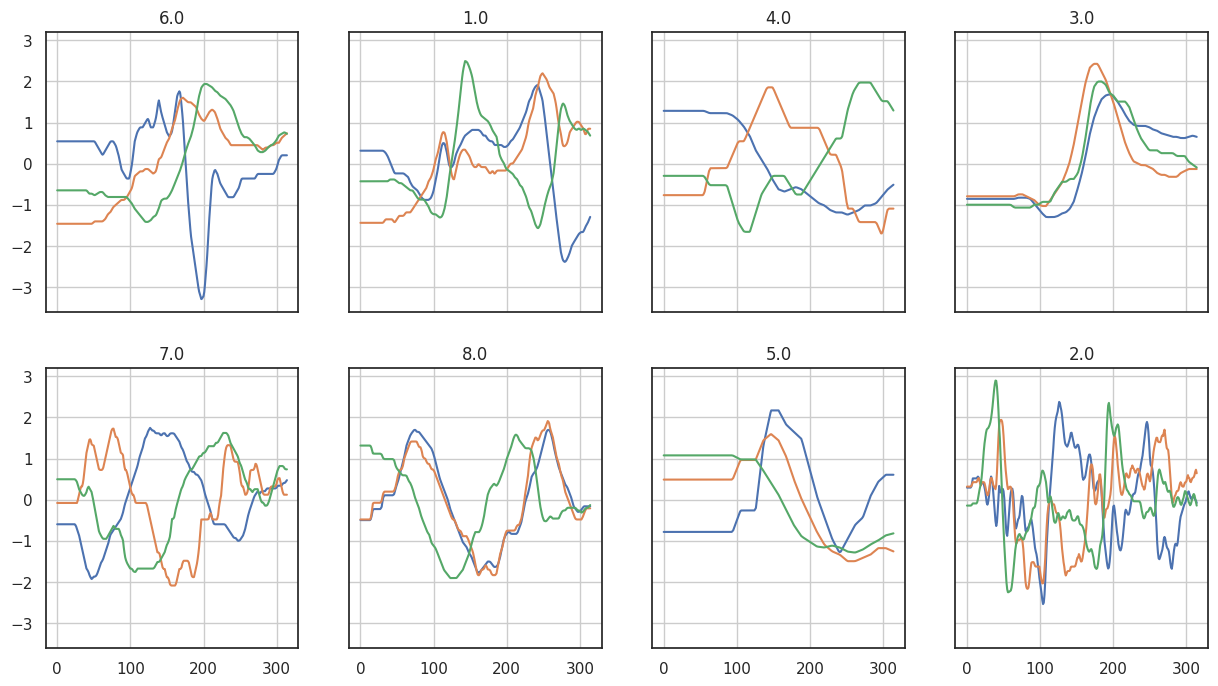

In [ ]:
plot = True
x_plot = []
lab_plot = []
if plot:
  for lab in set_y_train:
    x_plot.append(X_train[np.where(y_train == lab)[0][0]])
    lab_plot.append(lab)

  fig, axs = plt.subplots(2, 4, figsize=(15,8), sharex=True, sharey=True)
  na = np.concatenate([axs[0], axs[1]])

  for i, ax in enumerate(na):
    sns.lineplot(ax=ax, data=x_plot[i][0])
    sns.lineplot(ax=ax,data=x_plot[i][1])
    sns.lineplot(ax=ax,data=x_plot[i][2])
    ax.set_title(lab_plot[i])
    ax.grid()

Dataset


In [ ]:
from avalanche.benchmarks.utils.classification_dataset import ClassificationDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

vars = X.shape[1]
out = len(set(y))

y_int = [int(float(numeric_string)) for numeric_string in y]
y_train_int = np.array(y_int)[np.array(splits[0])]
y_test_int = np.array(y_int)[np.array(splits[1])]
y_train_int = y_train_int -1
y_test_int = y_test_int -1

task_labels_train = []
for y in y_train:
  for idx, t in enumerate(task_classes_arr):
    if y in t:
      task_labels_train.append(idx)

task_labels_test = []
for y in y_test:
  for idx, t in enumerate(task_classes_arr):
    if y in t:
      task_labels_test.append(idx)
#train
avds_train = AvalancheDataset(TensorDataset(torch.tensor(X_train),torch.from_numpy(y_train_int)))
avds_train.targets = torch.from_numpy(y_train_int)
sup_data_train_avds = make_classification_dataset(avds_train,task_labels=task_labels_train)
#test
avds_test = AvalancheDataset(TensorDataset(torch.tensor(X_test),torch.from_numpy(y_test_int)))
avds_test.targets = torch.from_numpy(y_test_int)
sup_data_test_avds = make_classification_dataset(avds_test, task_labels=task_labels_test)

In [ ]:

len(sup_data_train_avds[0]), sup_data_train_avds[0][1], sup_data_train_avds[0][0].shape


(3, tensor(0), torch.Size([3, 315]))

Benchmark


In [ ]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark


scenario = nc_benchmark(
    sup_data_train_avds, sup_data_test_avds , n_experiences=4, shuffle=True, seed=1234,task_labels=True
)


train_stream = scenario.train_stream

for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')

Task 0 batch 0 -> train
This batch contains 30 patterns
Task 1 batch 1 -> train
This batch contains 30 patterns
Task 2 batch 2 -> train
This batch contains 30 patterns
Task 3 batch 3 -> train
This batch contains 30 patterns


In [ ]:
scenario.task_labels

[[0], [1], [2], [3]]

Model & strategy

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SimpleMLP
from avalanche.training.supervised import ICaRL, Naive, CWRStar, Replay, GDumb, Cumulative, LwF, GEM, AGEM, EWC
from avalanche.training.plugins import EWCPlugin

model = InceptionTime(3, 10)#
# model= SimpleMLP(num_classes=9, input_size=3*315)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
# cl_strategy = Naive(
#     model, optimizer, criterion,
#     train_mb_size=100, train_epochs=20, eval_mb_size=100

# )

cl_strategy = ICaRL(
    feature_extractor= model.feature_extractor, classifier=model.classifier, optimizer=optimizer, memory_size = 2000,
    buffer_transform = None, fixed_memory = True,
    train_mb_size=100, train_epochs=10, eval_mb_size=100
    )


In [ ]:
#a = scenario.original_train_dataset

In [ ]:
# experience.dataset[0][0].shape,len(experience.dataset[0])

Train & Testing

In [ ]:
# TRAINING LOOP
print('Starting experiment...')
results = []
exp_classes = []
for experience in scenario.train_stream:
    #print(experience.current_experience, scenario.original_train_dataset[0][0].shape)
    print("Start of experience: ", experience.current_experience)
    exp_classes.append(experience.classes_in_this_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [5, 7]
-- >> Start of training phase << --
100%|██████████| 1/1 [00:02<00:00,  2.82s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6687
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0333
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6684
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0333
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6679
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0333
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6670
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0667
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6660
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0667
100%|██████████| 1/1 [00:01

In [ ]:
# from avalanche.models.dynamic_modules import MultiTaskModule, DynamicModule
# isinstance(model, MultiTaskModule)

In [ ]:
# len(results)
# len(results[-1])
# results[-1]

Results

In [ ]:
disp = range(2,10,2) # 10 = offset(2) * 2 *numExp
temp_Acc = []
temp_task_acc = []
Acc_over_Tasks = []
temp_Acc=[list(r.values()) for r in results]
for a in temp_Acc:
  for x in disp:
    if a[x] == 0:
      temp_task_acc.append(np.nan)
    else:
      temp_task_acc.append(a[x])
  Acc_over_Tasks.append(temp_task_acc)
  temp_task_acc = []
Acc_over_Tasks

[[0.75, nan, nan, nan],
 [0.7125, 0.3625, nan, nan],
 [0.6625, 0.4125, 0.4375, nan],
 [0.65, 0.4125, 0.6125, 0.825]]

<Axes: >

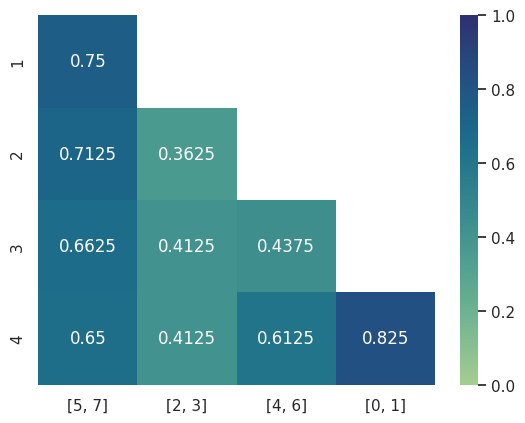

In [ ]:
# 50 ep
# [[0.7625, 0.0, 0.0, 0.0],
#  [0.7125, 0.4, 0.0, 0.0],
#  [0.6375, 0.375, 0.5, 0.0],
#  [0.625, 0.35, 0.4625, 0.775]]
import seaborn as sns
#sns.set_theme()
sns.set_style(style='white')

nan_mask = np.isnan(Acc_over_Tasks)
sns.heatmap(Acc_over_Tasks, vmin=0, vmax=1,mask = nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 5), xticklabels=exp_classes, cmap="crest")


In [ ]:
exp_classes

[[5, 7], [2, 3], [4, 6], [0, 1]]

In [ ]:
# from avalanche.benchmarks.classic import SplitMNIST
# model = InceptionTime(vars, out)#
# model= SimpleMLP()#(num_classes=21, input_size=3*182)
# optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = CrossEntropyLoss()
# cl_strategy = Naive(
#     model, optimizer, criterion,
#     train_mb_size=100, train_epochs=4, eval_mb_size=100

# )
# # scenario
# benchmark = SplitMNIST(n_experiences=5, seed=1)

# # TRAINING LOOP
# print('Starting experiment...')
# results = []
# experience = benchmark.train_stream[0]
# experience.dataset[0][0].shape,len(experience.dataset[0])


# for experience in benchmark.train_stream:

#     t = experience.task_label
#     exp_id = experience.current_experience
#     training_dataset = experience.dataset
#     print('Task {} batch {} -> train'.format(t, exp_id))
#     print('This batch contains', len(training_dataset), 'patterns')
#     print(experience.current_experience, benchmark.original_train_dataset[0][0].shape)
#     print("Start of experience: ", experience.current_experience)
#     print("Current Classes: ", experience.classes_in_this_experience)

#     cl_strategy.train(experience)
#     # print('Training completed')

#     # print('Computing accuracy on the whole test set')
#     results.append(cl_strategy.eval(benchmark.test_stream))